In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing as scale
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn import mixture
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
input_file = ["Backdoor.csv" , "DDoS_HTTP.csv" , "DDoS_ICMP.csv" , "DDoS_TCP.csv" , "DDoS_UDP.csv"  , "Password.csv" , "Port_Scanning.csv" ,"Ransomware.csv", "SQL_injection.csv" , "Uploading.csv" , "Vulnerability_scanner.csv" ,"XSS.csv" ]

In [3]:
def pred(x, clfs, p_nodes, gms):
    p_x_node = np.zeros((len(x), len(clfs))) # p[x, in node i] = p(x | x in Node i) * p(x in Node i)
    p_y_given_node = np.zeros((len(x), len(clfs))) # p[y | x, node i]
    for i in tqdm(range(len(clfs))):
        p_x_node[:, i] = p_nodes[i] * np.exp(gms[i].score_samples(x))
        p_y_given_node[:, i] = clfs[i].predict_proba(x)[:, 1]
    
    p_y = p_y_given_node * p_x_node / (np.sum(p_x_node, axis=-1, keepdims=True) + 1e-10)

    p_y = np.hstack([1-np.sum(p_y, axis=-1, keepdims=True), p_y])

    return np.argmax(p_y, axis=-1)

In [4]:
columns_to_drop_bi = ['Attack_type','Attack_label']

data_list = []
for i in range(len(input_file)):
    data = pd.read_csv(input_file[i])
    data.drop(columns = columns_to_drop_bi, inplace = True)
    data_list.append(data)



In [5]:
rs = 42 # set the random state

In [6]:
from sklearn.svm import SVC
clfs = [] # This is going to contain 14 different classifiers
n_samples = []
x_train_list = []
y_train_list = []
x_test_list = []
y_test_list = []
y = [np.ones(len(data_list[i])) * (i + 1) for i in range(len(data_list))]
for i in tqdm(range(len(input_file))): # reading the data
    data0 = pd.read_csv(input_file[i])
    y[i][data0.Attack_type =="Normal"] = 0
    n_samples.append(len(y[i])) # the number of this node
    x = data_list[i]
    x_train, x_test, y_train, y_test = train_test_split(x, y[i], test_size = 0.25, random_state = rs)
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
x_train_full = pd.concat(x_train_list, ignore_index=True)
scaler = scale.StandardScaler().fit(x_train_full)

for i in range(len(input_file)):
    x_train_list[i] = scaler.transform(x_train_list[i])
    classifier = SVC(kernel = 'rbf', random_state = 41, gamma='scale',max_iter=-1, probability=True)
    classifier.fit(x_train_list[i], y_train_list[i])
    clfs.append(classifier)

total_n_samples = np.sum(n_samples)
print('total number is ',total_n_samples)
p_nodes =  np.array(n_samples) / total_n_samples
print('The proportion of the nodes are:', p_nodes)




total number is  155169
The proportion of the nodes are: [0.07765726 0.08044133 0.10732814 0.07805038 0.11043443 0.07608478
 0.07670991 0.08321894 0.07854017 0.07821794 0.07674858 0.07656813]


In [7]:
from sklearn.mixture import GaussianMixture
gms = []
K = 15 # The number of the components of the GMM, one could change it by analyzing the graph
for i in tqdm(range(len(input_file))):
    gm = GaussianMixture(n_components = K).fit(x_train_list[i])  
    gms.append(gm)

In [8]:
for i in range(len(input_file)):
    x_test_list[i] = scaler.transform(x_test_list[i])

In [9]:
x_test = np.vstack(x_test_list)
y_test = np.hstack(y_test_list)
x_train = np.vstack(x_train_list)
y_train = np.hstack(y_train_list)

prediction = pred(x_test, clfs, p_nodes, gms)

In [10]:
correct = prediction == y_test
accuracy = np.mean(correct)
print('Overall accuracy is:', accuracy)

Overall accuracy is: 0.5727872570751069


In [11]:
recalls = []
for i in range(len(input_file)+1):
    if len(correct[y_test==i]) == 0:
        recalls.append(0)
    else:
        recalls.append(np.mean(correct[y_test==i]))
print('Recalls:', recalls)
precisions = []
for i in range(len(input_file)+1):
    if len(correct[prediction==i]) == 0:
        precisions.append(0)
    else:
        precisions.append(np.mean(correct[prediction==i]))
print('Precision:', precisions)

Recalls: [0.46224066390041496, 0.5911949685534591, 0.5338145896656535, 0.9997157475838545, 0.5918686473807663, 0.9997241379310344, 0.1548956661316212, 0.9674473997618103, 0.07647058823529412, 0.7766536964980545, 0.186328125, 0.8068226894089647, 0.13365155131264916]
Precision: [0.8470194647201946, 0.5231304347826087, 0.41679026994956986, 1.0, 1.0, 1.0, 0.4223194748358862, 0.6202596080427589, 0.43243243243243246, 0.1669594312003346, 0.792358803986711, 0.8662691652470187, 0.8842105263157894]


Centralized:

In [12]:
classifier = LogisticRegression(max_iter=10000)
classifier.fit(x_train, y_train)


LogisticRegression(max_iter=10000)

In [13]:
# pred_full = classifier.predict(X_test)
pred_full = classifier.predict(x_test)
# correct_full = pred_full == Y_test
correct_full = pred_full == y_test
accuracy_full = np.mean(correct_full)
print('Overall accuracy is:', accuracy_full)
accs_full = []
for i in range(len(input_file)+1):
    if len(correct[y_test==i]) == 0:
        accs_full.append(0)
    else:
        accs_full.append(np.mean(correct_full[y_test==i]))
print('Recalls:', accs_full)
recalls_full = []
for i in range(len(input_file)+1):
    if len(correct_full[pred_full==i]) == 0:
        recalls_full.append(0)
    else:
        recalls_full.append(np.mean(correct_full[pred_full==i]))
print('Precisions:', recalls_full)

Overall accuracy is: 0.5719624722923862
Recalls: [0.8720331950207469, 0.3132861635220126, 0.5296352583586627, 0.9991472427515634, 0.8213448006254886, 0.9939310344827587, 0.09751203852327447, 0.6978959904724097, 0.27242647058823527, 0.26459143968871596, 0.066015625, 0.7679492264974217, 0.0]
Precisions: [0.36833987661245093, 0.5577326801959412, 0.37829036635006785, 0.9997155858930603, 0.7249827467218771, 0.9997225305216426, 0.6603260869565217, 0.7009569377990431, 0.47744845360824745, 0.29272492466637967, 0.5888501742160279, 0.8189509306260575, 0]


Balancing the data

In [14]:
columns_to_drop_bi = ['Attack_type']

data_list = []
for i in range(len(input_file)):
    data = pd.read_csv(input_file[i])
    data['attack_type'] = i + 1
    data.loc[data.Attack_type == 'Normal', 'attack_type'] = 0
    data.drop(columns = columns_to_drop_bi, inplace = True)
    if len(data) < 2000:
        data_list.append(data)
    else:
        data0 = data[data['attack_type'].isin([0])]
        x1 = data0.sample(n = 1000, random_state = i + 42, axis = 0)
        data1 = data[data['attack_type'].isin([i+1])]
        x2 = data1.sample(n = 1000, random_state = i + 43, axis = 0)   
        data_selected = pd.concat([x1, x2], ignore_index=True)  
        data_list.append(data_selected) 
for i in range(len(data_list)):
    print(len(data_list[i]))  


rs = 42 # set the random state



clfs = [] # This is going to contain 14 different classifiers
n_samples = []
x_train_list = []
y_train_list = []
x_test_list = []
y_test_list = []
y = [np.ones(len(data_list[i])) * (i + 1) for i in range(len(data_list))]
for i in tqdm(range(len(input_file))): # reading the data
    data0 = data_list[i]
    y[i][data0.attack_type == 0] = 0
    n_samples.append(len(y[i])) # the number of this node
    x = data_list[i]
    x.drop(columns='attack_type')
    x.drop(columns='Attack_label')
    x_train, x_test, y_train, y_test = train_test_split(x, y[i], test_size = 0.25, random_state = rs)
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)

x_train_full = pd.concat(x_train_list, ignore_index=True)
scaler = scale.StandardScaler().fit(x_train_full)

for i in range(len(input_file)):
    x_train_list[i] = scaler.transform(x_train_list[i])

for i in tqdm(range(len(input_file))):
    classifier = LogisticRegression(max_iter=10000)
    # classifier = SVC(kernel = 'rbf', random_state = rs, gamma='scale', max_iter=-1, probability=True)
    # classifier.fit(data_list[i], y[i])
    classifier.fit(x_train_list[i], y_train_list[i])
    clfs.append(classifier)

total_n_samples = np.sum(n_samples)
print('total number is ',total_n_samples)
p_nodes =  np.array(n_samples) / total_n_samples
print('The proportion of the nodes are:', p_nodes)

for i in range(len(input_file)):
    x_test_list[i] = scaler.transform(x_test_list[i])

x_test = np.vstack(x_test_list)
y_test = np.hstack(y_test_list)
x_train = np.vstack(x_train_list)
y_train = np.hstack(y_train_list)

# GMM
from sklearn.mixture import GaussianMixture
gms = []
K = 15 # The number of the components of the GMM, one could change it by analyzing the graph
for i in tqdm(range(len(input_file))):
    x = x_train_list[i]
    gm = GaussianMixture(n_components = K).fit(x)  
    gms.append(gm)

prediction_b = pred(x_test, clfs, p_nodes, gms)

correct_b = prediction_b == y_test

accs_b = []
for i in range(len(input_file)+1):
    if len(correct_b[y_test==i]) == 0:
        accs_b.append(0)
    else:
        accs_b.append(np.mean(correct_b[y_test==i]))
print('Accuracies:', accs_b)
recalls_b = []
for i in range(len(input_file)+1):
    if len(correct_b[prediction_b==i]) == 0:
        recalls_b.append(0)
    else:
        recalls_b.append(np.mean(correct_b[prediction_b==i]))
print('Recalls:', recalls_b)

classifier = LogisticRegression(max_iter=10000)
classifier.fit(x_train, y_train)

# pred_full = classifier.predict(X_test)
pred_full_b = classifier.predict(x_test)
# correct_full = pred_full == Y_test
correct_full_b = pred_full_b == y_test
accuracy_full_b = np.mean(correct_full_b)
print('Overall accuracy is:', accuracy_full_b)
accs_full_b = []
for i in range(len(input_file)+1):
    if len(correct_b[y_test==i]) == 0:
        accs_full_b.append(0)
    else:
        accs_full_b.append(np.mean(correct_full_b[y_test==i]))
print('Recalls:', accs_full_b)
recalls_full_b = []
for i in range(len(input_file)+1):
    if len(correct_full_b[pred_full_b==i]) == 0:
        recalls_full_b.append(0)
    else:
        recalls_full_b.append(np.mean(correct_full_b[pred_full_b==i]))
print('Precisions:', recalls_full_b)


2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000



total number is  24000
The proportion of the nodes are: [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]



Accuracies: [1.0, 1.0, 0.9958847736625515, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9876543209876543, 0.9958847736625515]
Recalls: [0.9983813531887342, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Overall accuracy is: 0.9803333333333333
Recalls: [1.0, 1.0, 0.9835390946502057, 0.9958847736625515, 0.9958847736625515, 0.9958847736625515, 0.9917695473251029, 0.9711934156378601, 0.8477366255144033, 0.897119341563786, 0.9794238683127572, 0.8600823045267489, 0.9958847736625515]
Precisions: [1.0, 0.9838056680161943, 0.9958333333333333, 0.9958847736625515, 1.0, 0.9958847736625515, 0.9917695473251029, 0.8872180451127819, 0.8879310344827587, 0.9396551724137931, 0.8981132075471698, 0.9766355140186916, 0.9718875502008032]


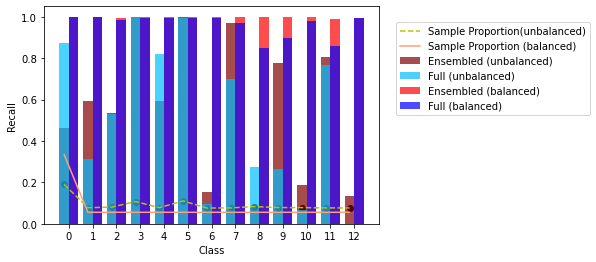

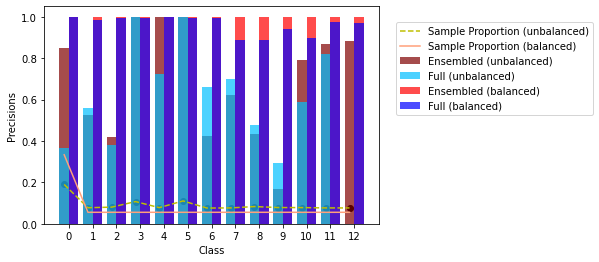

In [15]:
p_balanced = [12000]
p_balanced += n_samples
p_balanced /= np.sum(p_balanced)
p_labels =[0.19,0.07765726, 0.08044133, 0.10732814, 0.07805038, 0.11043443, 0.07608478,
 0.07670991, 0.08321894, 0.07854017, 0.07821794, 0.07674858, 0.07656813]
fig,ax = plt.subplots()
width = 0.4
x1 = np.arange(len(input_file)+1)
ax.bar(x1, np.array(recalls),width, alpha=0.7, label='Ensembled (unbalanced)', color='maroon')
ax.bar(x1, np.array(accs_full),width, alpha=0.7, label='Full (unbalanced)', color='deepskyblue')
ax.bar(x1+width, np.array(accs_b),width, alpha=0.7, label='Ensembled (balanced)', color='r')
ax.bar(x1+width, np.array(accs_full_b),width, alpha=0.7,  label='Full (balanced)', color='b')
plt.plot(x1, p_labels, color='y', linestyle= '--',label='Sample Proportion(unbalanced)')
plt.plot(x1, p_balanced, color='lightsalmon',linestyle= '-', label='Sample Proportion (balanced)')

ax.set_xticks(x1 +width/2)#将坐标设置在指定位置

ax.set_xticklabels(x1)#将横坐标替换成
plt.scatter(x1, p_labels, color='k')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc=3, borderaxespad=0)
plt.show()


fig,ax = plt.subplots()
ax.bar(x1, np.array(precisions),width, alpha=0.7, label='Ensembled (unbalanced)', color='maroon')
ax.bar(x1, np.array(recalls_full),width, alpha=0.7, label='Full (unbalanced)', color='deepskyblue')
ax.bar(x1+width, np.array(recalls_b),width, alpha=0.7, label='Ensembled (balanced)', color='r')
ax.bar(x1+width, np.array(recalls_full_b),width, alpha=0.7,  label='Full (balanced)', color='b')
plt.plot(x1, p_labels, color='y', linestyle= '--',label='Sample Proportion (unbalanced)')
plt.plot(x1, p_balanced, color='lightsalmon',linestyle= '-', label='Sample Proportion (balanced)')

ax.set_xticks(x1 +width/2)#将坐标设置在指定位置

ax.set_xticklabels(x1)#将横坐标替换成
plt.scatter(x1, p_labels, color='k')
plt.xlabel('Class')
plt.ylabel('Precisions')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc=3, borderaxespad=0)
plt.show()